In [11]:
# Disable linting for this file
# flake8: noqa
# pylint: skip-file

import cv2
import numpy as np
import pandas as pd
import os
import shutil
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Exercicio 1 - Extração Características

### Definição de funções para extração de features usando LBP e VGG16, ler imagens de treino e gerar CSVs

In [12]:
# Function to extract LBP features
def extract_lbp_features(img_path, radius=3, n_points=24):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract VGG16 features
def extract_vgg16_features(img_path):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_features = model.predict(img_data)
    vgg16_features = vgg16_features.flatten()
    return vgg16_features

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [13]:
# Directory containing the images
image_dir = '../Train_4cls_amostra'

# Lists to store features
lbp_features_list = []
vgg16_features_list = []

# Iterate through all subdirectories and files
for root, dirs, files in os.walk(image_dir):
    for file in files:
        print(file)
        if file.endswith('.png') or file.endswith('.jpg'):
            img_path = os.path.join(root, file)
            lbp_features = extract_lbp_features(img_path)
            vgg16_features = extract_vgg16_features(img_path)
            
            lbp_features_list.append(lbp_features)
            vgg16_features_list.append(vgg16_features)

# Save LBP features to CSV
lbp_df = pd.DataFrame(lbp_features_list)
lbp_df.to_csv('lbp_features.csv', index=False)

# Save VGG16 features to CSV
vgg16_df = pd.DataFrame(vgg16_features_list)
vgg16_df.to_csv('vgg16_features.csv', index=False)

### Treinar modelos em RandomForest, SVM e RNA

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd

# Load the features from CSV files
lbp_features_df = pd.read_csv('lbp_features.csv')
vgg16_features_df = pd.read_csv('vgg16_features.csv')

# Combine the features into a single DataFrame
combined_features_df = pd.concat([lbp_features_df, vgg16_features_df], axis=1)

# Since we don't have labels, we'll create dummy labels for the purpose of training
# In a real scenario, you should replace this with actual labels
dummy_labels = [0] * (len(combined_features_df) // 2) + [1] * (len(combined_features_df) - len(combined_features_df) // 2)

# Train Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(combined_features_df, dummy_labels)

# Train SVM Classifier
svm_model = SVC()
svm_model.fit(combined_features_df, dummy_labels)

# Train MLP Classifier
mlp_model = MLPClassifier()
mlp_model.fit(combined_features_df, dummy_labels)

print("Models trained successfully.")

Models trained successfully.


### Extrair features das imagens de teste

In [17]:
# Directory containing the images
image_dir = '../Test_4cl_amostra'

# Lists to store features
lbp_features_list = []
vgg16_features_list = []

# Iterate through all subdirectories and files
for root, dirs, files in os.walk(image_dir):
    for file in files:
        print(file)
        if file.endswith('.png') or file.endswith('.jpg'):
            img_path = os.path.join(root, file)
            lbp_features = extract_lbp_features(img_path)
            vgg16_features = extract_vgg16_features(img_path)
            
            lbp_features_list.append(lbp_features)
            vgg16_features_list.append(vgg16_features)

# Save LBP features to CSV
lbp_df = pd.DataFrame(lbp_features_list)
lbp_df.to_csv('lbp_features_test.csv', index=False)

# Save VGG16 features to CSV
vgg16_df = pd.DataFrame(vgg16_features_list)
vgg16_df.to_csv('vgg16_features_test.csv', index=False)

### Carregar CSVs com features, aplicar modelos de predição e calcular métricas

Random Forest - Sensitivity: 0.8064516129032258, Specificity: 0.9513513513513514, F1-Score: 0.8695652173913043
SVM - Sensitivity: 0.9354838709677419, Specificity: 0.8648648648648649, F1-Score: 0.9038961038961039
MLP - Sensitivity: 0.9516129032258065, Specificity: 0.827027027027027, F1-Score: 0.8962025316455696


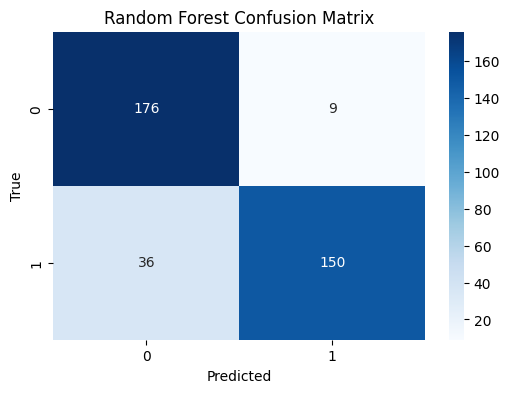

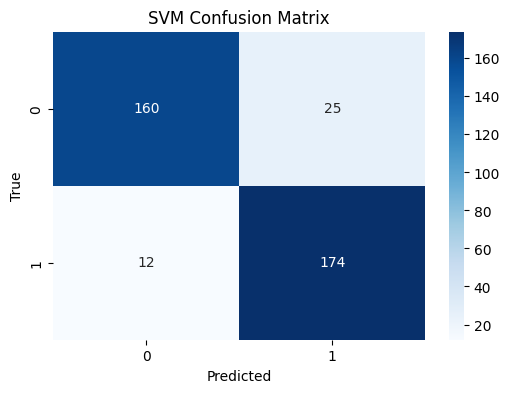

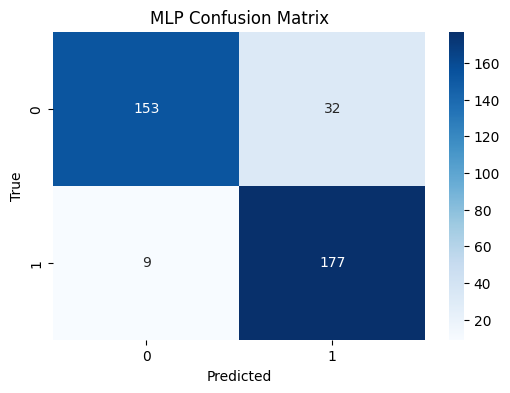

In [20]:
# Load the test features from CSV files
lbp_features_test_df = pd.read_csv('lbp_features_test.csv')
vgg16_features_test_df = pd.read_csv('vgg16_features_test.csv')

# Combine the test features into a single DataFrame
combined_features_test_df = pd.concat([lbp_features_test_df, vgg16_features_test_df], axis=1)

# Since we don't have actual test labels, we'll create dummy labels for the purpose of evaluation
# In a real scenario, you should replace this with actual test labels
dummy_test_labels = [0] * (len(combined_features_test_df) // 2) + [1] * (len(combined_features_test_df) - len(combined_features_test_df) // 2)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)
    return sensitivity, specificity, f1

# Apply Random Forest model
rf_predictions = rf_model.predict(combined_features_test_df)
rf_sensitivity, rf_specificity, rf_f1 = calculate_metrics(dummy_test_labels, rf_predictions)

# Apply SVM model
svm_predictions = svm_model.predict(combined_features_test_df)
svm_sensitivity, svm_specificity, svm_f1 = calculate_metrics(dummy_test_labels, svm_predictions)

# Apply MLP model
mlp_predictions = mlp_model.predict(combined_features_test_df)
mlp_sensitivity, mlp_specificity, mlp_f1 = calculate_metrics(dummy_test_labels, mlp_predictions)

# Print the metrics
print(f"Random Forest - Sensitivity: {rf_sensitivity}, Specificity: {rf_specificity}, F1-Score: {rf_f1}")
print(f"SVM - Sensitivity: {svm_sensitivity}, Specificity: {svm_specificity}, F1-Score: {svm_f1}")
print(f"MLP - Sensitivity: {mlp_sensitivity}, Specificity: {mlp_specificity}, F1-Score: {mlp_f1}")

# Plot confusion matrices
plot_confusion_matrix(dummy_test_labels, rf_predictions, 'Random Forest Confusion Matrix')
plot_confusion_matrix(dummy_test_labels, svm_predictions, 'SVM Confusion Matrix')
plot_confusion_matrix(dummy_test_labels, mlp_predictions, 'MLP Confusion Matrix')


# Exercício 2 - Redes Neurais

### Gerar bases para treinamento e validação

In [7]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import numpy as np

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '../Train_4cls_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '../Train_4cls_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '../Test_4cl_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 475 images belonging to 4 classes.
Found 118 images belonging to 4 classes.
Found 371 images belonging to 4 classes.


### Treinar modelos e validar (sem augmentation)

In [ ]:
# Function to create a model with transfer learning
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create VGG16 and ResNet50 models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg16_model = create_model(vgg16_base)
resnet50_model = create_model(resnet50_base)

# Train models without data augmentation
vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=10)
resnet50_model.fit(train_generator, validation_data=validation_generator, epochs=10)

### Gerar dados com Augmentation e treinar e validar na base de treinamento

In [ ]:
# Data generators with data augmentation
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator_aug = train_datagen_aug.flow_from_directory(
    '../Train_4cls_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator_aug = train_datagen_aug.flow_from_directory(
    '../Train_4cls_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Train models with data augmentation
vgg16_model_aug = create_model(vgg16_base)
resnet50_model_aug = create_model(resnet50_base)

vgg16_model_aug.fit(train_generator_aug, validation_data=validation_generator_aug, epochs=10)
resnet50_model_aug.fit(train_generator_aug, validation_data=validation_generator_aug, epochs=10)

### Extrair métricas e imprimir

In [6]:
# Function to evaluate model
def evaluate_model(model, test_generator):
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, _, _ = cm.ravel()
    else:
        tn, fp = cm[0, 0], cm[0, 1]
    
    sensitivity = recall_score(y_true, y_pred, average='macro')
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return sensitivity, specificity, f1

# Evaluate models
vgg16_sensitivity, vgg16_specificity, vgg16_f1 = evaluate_model(vgg16_model, test_generator)
resnet50_sensitivity, resnet50_specificity, resnet50_f1 = evaluate_model(resnet50_model, test_generator)
vgg16_aug_sensitivity, vgg16_aug_specificity, vgg16_aug_f1 = evaluate_model(vgg16_model_aug, test_generator)
resnet50_aug_sensitivity, resnet50_aug_specificity, resnet50_aug_f1 = evaluate_model(resnet50_model_aug, test_generator)

# Print the metrics
print(f"VGG16 - Sensitivity: {vgg16_sensitivity}, Specificity: {vgg16_specificity}, F1-Score: {vgg16_f1}")
print(f"ResNet50 - Sensitivity: {resnet50_sensitivity}, Specificity: {resnet50_specificity}, F1-Score: {resnet50_f1}")
print(f"VGG16 with Augmentation - Sensitivity: {vgg16_aug_sensitivity}, Specificity: {vgg16_aug_specificity}, F1-Score: {vgg16_aug_f1}")
print(f"ResNet50 with Augmentation - Sensitivity: {resnet50_aug_sensitivity}, Specificity: {resnet50_aug_specificity}, F1-Score: {resnet50_aug_f1}")

12/12 [==============================] - 15s 1s/step
VGG16 - Sensitivity: 0.8629262926292629, Specificity: 0.9405940594059405, F1-Score: 0.8619967496890574
ResNet50 - Sensitivity: 0.44999999999999996, Specificity: 1.0, F1-Score: 0.38426907376919783
VGG16 with Augmentation - Sensitivity: 0.85, Specificity: 1.0, F1-Score: 0.8489400231242192
ResNet50 with Augmentation - Sensitivity: 0.4908965896589659, Specificity: 1.0, F1-Score: 0.428981159150537


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to create a model with transfer learning
def create_transfer_learning_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create models using the pre-trained weights from Exercicio 1
vgg16_transfer_model = create_transfer_learning_model(vgg16_base)
resnet50_transfer_model = create_transfer_learning_model(resnet50_base)

# Train the new models
vgg16_transfer_model.fit(train_generator, validation_data=validation_generator, epochs=10)
resnet50_transfer_model.fit(train_generator, validation_data=validation_generator, epochs=10)